# 1. Introduction

Due to the rising awareness of environmental protection, people are intending to purchase electric car. By the end of 2020, there are more than 10 million light-duty plug-in vehicles in use globally. Europe is taking 30% of that figure. [1] Germany is certainly taking the lead of this trend, by having over 700,000 plug-in passenger cars at the end of 200. 

Charging station, depending on its location, usage, accessibility for different chargers, is playing a vital role in electric car infrastructural facilities. Given the optimistic trend of electric cars, it is certainly needed to speed up the installation of charging infrastructure in order to match the rocket-speed growth of use of electric cars.

Hamburg is the second largest city in Germany after Berlin and 7th largest city in the European Union with a population of over 1.84 million. Hamburg has been one of the pioneers in e-mobility for years. With over 1,000 publicly accessible charging points, the Free and Hanseatic City is one of the German cities with the most extensive charging infrastructure. There are almost 28,000 publicly accessible charging points throughout Germany (as of June 2020).[2] As part of the ELBE-project, Hamburg is aiming at adding over 7400 charging stations by end of 2022. 

# 2. Business Problem

In order to reach the ambicious aim, this report would like to offer some insipration for the choose of location of charging station in Hamburg. According to Master plan for charging infrastructure for the Federal Republic[3], 60-85% chargingstation would belong to private buildings or company buildings, with regular or nightcharging type. Meanwhile, 15-40% charging station will be at shops, roads, public parking place (e.g. in shopping center), with fast charging type. For fast charging type is the fastest way to charge your electric vehicle, providing between 60-200 miles of range in 20-30 mins. 


In public venues, supermarket and shopping mall are the most visited venues, where people will go with cars and the customer dwell time in supermarket and shopping malls is normally more than 30 min. 

Therefore, this report is going to focus on the research question: the distribution of the supermarket and shopping mall in Hamburg, and accoordingly to suggest the locaiton of fast charging station. 



# 3. Data Preparation

Data: 
1. Hamburg borough and neighborhood data
    >data source: Wikipedia 

2. The coordinations for the neighborhood
    >data source: Foursquare API

3. The existinng fast charging stations in Hamburg
    >data source: Bundestnetsagentur: https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/E-Mobilitaet/E-Mobilitaet-node.html  

4. The most popular venues/locations in Hamburg(assumming, there are the most visited public place, where people can access with e-cars.) The charging station shall be near by those places. 
    >data source: Foursquare
    

In [384]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium


print('libraries are loaded!')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

libraries are loaded!


## 3.1 Using BeautifulSoup to get the Neiborhood information from Wikipedia

In [296]:
!pip install bs4 
from bs4 import BeautifulSoup

In [297]:
link ='https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Stadtteile_Hamburgs'
data = requests.get(link).text
soup = BeautifulSoup(data, 'html5lib')
tables = soup.find_all('table')
data_Hamburg1 = pd.read_html(str(tables[1]), flavor ='bs4')[0]
data_Hamburg1.head()

,Stadtteil,Ortsteile,Bezirk,Fläche (km²),Einwohner,Bevölkerungs­dichte (Einwohner/km²),Koordinaten,Karte
0,Hamburg-Altstadt,101–102,Hamburg-Mitte,24,2350.000,979,"53° 33′ 0″ N, 10° 0′ 0″ O",NaN
1,HafenCity,103–104,Hamburg-Mitte,22,4925.000,2239,"53° 32′ 28″ N, 10° 0′ 1″ O",NaN
2,Neustadt,105–108,Hamburg-Mitte,23,12.762,5549,"53° 33′ 7″ N, 9° 59′ 8″ O",NaN
3,St. Pauli,109–112,Hamburg-Mitte,25,22.097,8839,"53° 33′ 25″ N, 9° 57′ 50″ O",NaN
4,St. Georg,113–114,Hamburg-Mitte,24,11.358,4733,"53° 33′ 18″ N, 10° 0′ 44″ O",NaN


In [298]:
import re

def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    lng = dms2dd(parts[4], parts[5], parts[6], parts[7])

    return (lat, lng)

dd = parse_dms("36°57'9' N 110°4'21' W")

print(dd)
print(dd2dms(dd[0]))


(36.9525, -110.07249999999999)
[36, 57, 9.000000000002046]


In [299]:
df=[]
for value in data_Hamburg1['Koordinaten']:
    coordinates = parse_dms(value)
    df.append({'coordinates': coordinates})

df = pd.DataFrame(df)

df.head()


,coordinates
0,"(53.55, 10.0)"
1,"(53.54111111111111, 10.000277777777777)"
2,"(53.551944444444445, 9.985555555555555)"
3,"(53.55694444444444, 9.963888888888889)"
4,"(53.555, 10.012222222222222)"


In [300]:
df = df.astype(str)
df.sample(5)

,coordinates
92,"(53.43722222222222, 9.98611111111111)"
47,"(53.572500000000005, 10.018611111111111)"
76,"(53.42472222222222, 10.2625)"
89,"(53.44916666666666, 10.015277777777778)"
29,"(53.55833333333333, 9.811111111111112)"


In [301]:
df[['Lat', 'Long']] = df['coordinates'].str.split(',', 1, expand=True)

In [302]:
df.head()

,coordinates,Lat,Long
0,"(53.55, 10.0)",(53.55,10.0)
1,"(53.54111111111111, 10.000277777777777)",(53.54111111111111,10.000277777777777)
2,"(53.551944444444445, 9.985555555555555)",(53.551944444444445,9.985555555555555)
3,"(53.55694444444444, 9.963888888888889)",(53.55694444444444,9.963888888888889)
4,"(53.555, 10.012222222222222)",(53.555,10.012222222222222)


In [303]:
Lat = []

for i in df['Lat']:
    l = i.replace('(', '')
    Lat.append({'Lat': l})

Lat = pd.DataFrame(Lat)

In [304]:
Lat.head()

,Lat
0,53.55
1,53.54111111111111
2,53.551944444444445
3,53.55694444444444
4,53.555


In [305]:
Long = []

for i in df['Long']:
    l = i.replace(')', '')
    Long.append({'Long': l})

Long = pd.DataFrame(Long)

In [166]:
Long.head()

,Long
0,10.0
1,10.000277777777777
2,9.985555555555555
3,9.963888888888889
4,10.012222222222222


In [306]:
result = pd.concat([Lat, Long], axis=1)
result.head()

,Lat,Long
0,53.55,10.0
1,53.54111111111111,10.000277777777777
2,53.551944444444445,9.985555555555555
3,53.55694444444444,9.963888888888889
4,53.555,10.012222222222222


In [307]:
result['Lat'] = result['Lat'].astype(float)
result['Long'] = result['Long'].astype(float)


In [308]:
result.head()

,Lat,Long
0,53.550000,10.000000
1,53.541111,10.000278
2,53.551944,9.985556
3,53.556944,9.963889
4,53.555000,10.012222


In [309]:
data = pd.concat([data_Hamburg1, result], axis=1)

In [310]:
data.head()

,Stadtteil,Ortsteile,Bezirk,Fläche (km²),Einwohner,Bevölkerungs­dichte (Einwohner/km²),Koordinaten,Karte,Lat,Long
0,Hamburg-Altstadt,101–102,Hamburg-Mitte,24,2350.000,979,"53° 33′ 0″ N, 10° 0′ 0″ O",NaN,53.550000,10.000000
1,HafenCity,103–104,Hamburg-Mitte,22,4925.000,2239,"53° 32′ 28″ N, 10° 0′ 1″ O",NaN,53.541111,10.000278
2,Neustadt,105–108,Hamburg-Mitte,23,12.762,5549,"53° 33′ 7″ N, 9° 59′ 8″ O",NaN,53.551944,9.985556
3,St. Pauli,109–112,Hamburg-Mitte,25,22.097,8839,"53° 33′ 25″ N, 9° 57′ 50″ O",NaN,53.556944,9.963889
4,St. Georg,113–114,Hamburg-Mitte,24,11.358,4733,"53° 33′ 18″ N, 10° 0′ 44″ O",NaN,53.555000,10.012222


In [311]:
data_Hamburg_stadt = data.drop(columns = ['Ortsteile', 'Fläche (km²)', 'Einwohner', 'Karte', 'Koordinaten'], inplace = False)
data_Hamburg_stadt.head()

,Stadtteil,Bezirk,Bevölkerungs­dichte (Einwohner/km²),Lat,Long
0,Hamburg-Altstadt,Hamburg-Mitte,979,53.550000,10.000000
1,HafenCity,Hamburg-Mitte,2239,53.541111,10.000278
2,Neustadt,Hamburg-Mitte,5549,53.551944,9.985556
3,St. Pauli,Hamburg-Mitte,8839,53.556944,9.963889
4,St. Georg,Hamburg-Mitte,4733,53.555000,10.012222


In [312]:
data_Hamburg_stadt.shape

(104, 5)

In [313]:
data_Hamburg_stadt = data_Hamburg_stadt.rename(columns={
    'Stadtteil':"Neighborhood", 
    'Bezirk': 'Borough', 
    'Bevölkerungs­dichte (Einwohner/km²)': 'Dencity of Population(people/km²)', 
    'Lat': 'Latitude', 
    'Long': 'Longitude'})


In [314]:
data_Hamburg_stadt.head()

,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude
0,Hamburg-Altstadt,Hamburg-Mitte,979,53.550000,10.000000
1,HafenCity,Hamburg-Mitte,2239,53.541111,10.000278
2,Neustadt,Hamburg-Mitte,5549,53.551944,9.985556
3,St. Pauli,Hamburg-Mitte,8839,53.556944,9.963889
4,St. Georg,Hamburg-Mitte,4733,53.555000,10.012222


## 3.2 Download and Clean up the Fast Charging Station Information

In [342]:
data_Hamburg_stadt.to_csv('data_Hamburg_stadt.csv')

In [343]:
data_chargingstation = pd.read_excel('Ladesaeulenkarte_Datenbankauszug.xlsx', index_col= 0)
data_1 = data_chargingstation.drop(data_chargingstation.index[[0,1,2,3]])

new_header = data_1.iloc[0]
data_chargingstation = data_1[1:]
data_chargingstation.columns = new_header

data_chargingstation.head()


Betreiber,Adresse,Postleitzahl Ort,Bundesland,Landkreis,Längengrad [DG],Breitengrad [DG],Inbetriebnahmedatum,Anschlussleistung [kW],Art der Ladeeinrichtung,Anzahl Ladepunkte,Steckertypen1,P1 [kW],Public Key1,Steckertypen2,P2 [kW],Public Key2,Steckertypen3,P3 [kW],Public Key3,Steckertypen4,P4 [kW],Public Key32
Ladesäulenregister Bundesnetzagentur,,,,,,,,,,,,,,,,,,,,,,
Albwerk GmbH & Co. KG,Ennabeurer Weg,72535 Heroldstatt,Baden-Württemberg,Landkreis Alb-Donau-Kreis,9.65907,48.4424,2020-01-11 00:00:00,22,Normalladeeinrichtung,2,AC Steckdose Typ 2,22,NaN,AC Steckdose Typ 2,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albwerk GmbH & Co. KG,Parkplatz Campingplatz,72589 Westerheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,9.609,48.5105,2019-01-07 00:00:00,22,Normalladeeinrichtung,2,AC Steckdose Typ 2,22,NaN,AC Steckdose Typ 2,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EnBW Energie Baden-Württemberg,Hauptstraße 91c,73340 Amstetten,Baden-Württemberg,Landkreis Alb-Donau-Kreis,9.87484,48.5785,2019-03-19 00:00:00,98,Schnellladeeinrichtung,2,AC Kupplung Typ 2,43,NaN,"DC Kupplung Combo, DC CHAdeMO",50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SWU Energie GmbH,Helfensteinerstraße 12,80143 Blaubeuren-Gerhausen,Baden-Württemberg,Landkreis Alb-Donau-Kreis,9.80557,48.399,2019-04-13 00:00:00,22,Normalladeeinrichtung,1,AC Steckdose Typ 2,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stadtwerke Eichstätt,Burgstraße,85072 Eichstätt,Baden-Württemberg,Landkreis Alb-Donau-Kreis,10.1036,48.5331,2020-12-15 00:00:00,22,Normalladeeinrichtung,2,AC Steckdose Typ 2,22,NaN,AC Steckdose Typ 2,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [346]:
data_chargingstation_Hamburg = data_chargingstation.loc[data_chargingstation['Bundesland']=='Hamburg']
data_chargingstation_Hamburg = data_chargingstation_Hamburg.drop(['Adresse', 'Inbetriebnahmedatum', 'Postleitzahl Ort', 'Landkreis'], axis
                                         =1, inplace=False)

data_chargingstation_Hamburg.head()

Betreiber,Bundesland,Längengrad [DG],Breitengrad [DG],Anschlussleistung [kW],Art der Ladeeinrichtung,Anzahl Ladepunkte,Steckertypen1,P1 [kW],Public Key1,Steckertypen2,P2 [kW],Public Key2,Steckertypen3,P3 [kW],Public Key3,Steckertypen4,P4 [kW],Public Key32
Ladesäulenregister Bundesnetzagentur,,,,,,,,,,,,,,,,,,
Stromnetz Hamburg GmbH,Hamburg,9.9976,53.5522,44,Normalladeeinrichtung,2,"AC Steckdose Typ 2, AC Schuko",22,NaN,"AC Steckdose Typ 2, AC Schuko",22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stromnetz Hamburg GmbH,Hamburg,10.0047,53.5494,44,Normalladeeinrichtung,2,"AC Steckdose Typ 2, AC Schuko",22,NaN,"AC Steckdose Typ 2, AC Schuko",22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stromnetz Hamburg GmbH,Hamburg,10.0011,53.5526,44,Normalladeeinrichtung,2,"AC Steckdose Typ 2, AC Schuko",22,NaN,"AC Steckdose Typ 2, AC Schuko",22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stromnetz Hamburg GmbH,Hamburg,10.0011,53.5553,44,Normalladeeinrichtung,2,"AC Steckdose Typ 2, AC Schuko",22,NaN,"AC Steckdose Typ 2, AC Schuko",22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stromnetz Hamburg GmbH,Hamburg,9.99313,53.5489,44,Normalladeeinrichtung,2,"AC Steckdose Typ 2, AC Schuko",22,NaN,"AC Steckdose Typ 2, AC Schuko",22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
data_fast_charging = data_chargingstation_Hamburg.loc[data_chargingstation_Hamburg['Art der Ladeeinrichtung'] == 'Schnellladeeinrichtung']
data_fast_charging.head()

Betreiber,Bundesland,Längengrad [DG],Breitengrad [DG],Anschlussleistung [kW],Art der Ladeeinrichtung,Anzahl Ladepunkte,Steckertypen1,P1 [kW],Public Key1,Steckertypen2,P2 [kW],Public Key2,Steckertypen3,P3 [kW],Public Key3,Steckertypen4,P4 [kW],Public Key32
Ladesäulenregister Bundesnetzagentur,,,,,,,,,,,,,,,,,,
Stromnetz Hamburg GmbH,Hamburg,10.0137,53.5483,61,Schnellladeeinrichtung,2,"DC Kupplung Combo, DC CHAdeMO",50,NaN,AC Steckdose Typ 2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stromnetz Hamburg GmbH,Hamburg,10.0124,53.5447,61,Schnellladeeinrichtung,2,"DC Kupplung Combo, DC CHAdeMO",50,NaN,AC Steckdose Typ 2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stromnetz Hamburg GmbH,Hamburg,10.0236,53.5531,61,Schnellladeeinrichtung,2,"DC Kupplung Combo, DC CHAdeMO",50,NaN,AC Steckdose Typ 2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stromnetz Hamburg GmbH,Hamburg,10.0082,53.553,61,Schnellladeeinrichtung,2,"DC Kupplung Combo, DC CHAdeMO",50,NaN,AC Steckdose Typ 2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stromnetz Hamburg GmbH,Hamburg,9.99472,53.5705,61,Schnellladeeinrichtung,2,"DC Kupplung Combo, DC CHAdeMO",50,NaN,AC Steckdose Typ 2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.3 Use Foursquare API to Explore Popular Venues in the Neighborhood of Hamburg

In [315]:
CLIENT_ID = 'RQEK1FE0KCZYXH01ESL5UUYU55PLDDB0ITEUU5BLTWLRXEIM' # your Foursquare ID
CLIENT_SECRET = 'BMFMAPT2HRBI1TUHVLWCMVIOXOMODHEQU2G5MM1UBO4ZBU31' # your Foursquare Secret
ACCESS_TOKEN = 'KWMPI4RYSZ2WY1TOAXDXLSDI2JHJDPSMKR0YBLSY1CHGYJQ3' # your FourSquare Access Token
VERSION = '20210520'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RQEK1FE0KCZYXH01ESL5UUYU55PLDDB0ITEUU5BLTWLRXEIM
CLIENT_SECRET:BMFMAPT2HRBI1TUHVLWCMVIOXOMODHEQU2G5MM1UBO4ZBU31


In [316]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [317]:
LIMIT = 100
radius = 1000

Hamburg_venues = getNearbyVenues(names=data_Hamburg_stadt['Neighborhood'],
                                  latitudes=data_Hamburg_stadt['Latitude'],
                                  longitudes=data_Hamburg_stadt['Longitude'], 
                                radius = radius)

Hamburg-Altstadt
HafenCity
Neustadt
St. Pauli
St. Georg
Hammerbrook
Borgfelde
Hamm
Horn
Billstedt
Billbrook
Rothenburgsort
Veddel
Wilhelmsburg
Kleiner Grasbrook
Steinwerder
Waltershof
Finkenwerder
Neuwerk
Altona-Altstadt
Sternschanze
Altona-Nord
Ottensen
Bahrenfeld
Groß Flottbek
Othmarschen
Lurup
Osdorf
Nienstedten
Blankenese
Iserbrook
Sülldorf
Rissen
Eimsbüttel
Rotherbaum
Harvestehude
Hoheluft-West
Lokstedt
Niendorf
Schnelsen
Eidelstedt
Stellingen
Hoheluft-Ost
Eppendorf
Groß Borstel
Alsterdorf
Winterhude
Uhlenhorst
Hohenfelde
Barmbek-Süd
Dulsberg
Barmbek-Nord
Ohlsdorf
Fuhlsbüttel
Langenhorn
Eilbek
Wandsbek
Marienthal
Jenfeld
Tonndorf
Farmsen-Berne
Bramfeld
Steilshoop
Wellingsbüttel
Sasel
Poppenbüttel
Hummelsbüttel
Lemsahl-Mellingstedt
Duvenstedt
Wohldorf-Ohlstedt
Bergstedt
Volksdorf
Rahlstedt
Lohbrügge
Bergedorf
Curslack
Altengamme
Neuengamme
Kirchwerder
Ochsenwerder
Reitbrook
Allermöhe
Billwerder
Moorfleet
Tatenberg
Spadenland
Neuallermöhe
Harburg
Neuland
Gut Moor
Wilstorf
Rönneburg


In [318]:
type(Hamburg_venues)

pandas.core.frame.DataFrame

In [319]:
Hamburg_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hamburg-Altstadt,53.55,10.0,GOOT - Finest Cuts,53.548509,10.000675,Comfort Food Restaurant
1,Hamburg-Altstadt,53.55,10.0,O-ren Ishii,53.548291,9.997890,Vietnamese Restaurant
2,Hamburg-Altstadt,53.55,10.0,Thalia Theater,53.552000,9.998338,Theater
3,Hamburg-Altstadt,53.55,10.0,Picasso,53.549934,9.995627,Spanish Restaurant
4,Hamburg-Altstadt,53.55,10.0,Park Hyatt Hamburg,53.550977,10.003158,Hotel


In [246]:
Hamburg_venues.to_csv('Hamburg_venues.csv')

In [401]:
Hamburg_venues[(Hamburg_venues['Venue Category'].str.contains('Supermarket', regex=False)) |
                 (Hamburg_venues['Venue Category'].str.contains('Shopping Mall', regex=False))].count()

Neighborhood              209
Neighborhood Latitude     209
Neighborhood Longitude    209
Venue                     209
Venue Latitude            209
Venue Longitude           209
Venue Category            209
dtype: int64

In [402]:
df_supermarket = Hamburg_venues[Hamburg_venues['Venue Category'].isin(['Supermarket'])].groupby(['Neighborhood']).count()

df_supermarket = df_supermarket.drop(columns = ['Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])

df_supermarket = df_supermarket.rename(columns = {'Neighborhood Latitude': 'Number of Supermarket'})

df_supermarket.head()

,Number of Supermarket
Neighborhood,
Allermöhe,1
Alsterdorf,3
Altona-Altstadt,2
Altona-Nord,3
Barmbek-Nord,4


In [403]:
df_shoppingmall = Hamburg_venues[Hamburg_venues['Venue Category'].isin(['Shopping Mall'])].groupby(['Neighborhood']).count()

df_shoppingmall = df_shoppingmall.drop(columns = ['Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])

df_shoppingmall = df_shoppingmall.rename(columns = {'Neighborhood Latitude': 'Number of Shopping Mall'})

df_shoppingmall.head()


,Number of Shopping Mall
Neighborhood,
Bergedorf,1
Billstedt,1
Bramfeld,1
Farmsen-Berne,1
Fuhlsbüttel,1


In [404]:
data_ss = data_Hamburg_stadt.merge(df_supermarket, how='left', on='Neighborhood')
data_ss.head()

,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude,Number of Supermarket
0,Hamburg-Altstadt,Hamburg-Mitte,979,53.550000,10.000000,NaN
1,HafenCity,Hamburg-Mitte,2239,53.541111,10.000278,1.0
2,Neustadt,Hamburg-Mitte,5549,53.551944,9.985556,NaN
3,St. Pauli,Hamburg-Mitte,8839,53.556944,9.963889,1.0
4,St. Georg,Hamburg-Mitte,4733,53.555000,10.012222,1.0


In [405]:
data_ss = data_ss.merge(df_shoppingmall, how='left', on='Neighborhood')
data_ss.head()

,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude,Number of Supermarket,Number of Shopping Mall
0,Hamburg-Altstadt,Hamburg-Mitte,979,53.550000,10.000000,NaN,1.0
1,HafenCity,Hamburg-Mitte,2239,53.541111,10.000278,1.0,NaN
2,Neustadt,Hamburg-Mitte,5549,53.551944,9.985556,NaN,NaN
3,St. Pauli,Hamburg-Mitte,8839,53.556944,9.963889,1.0,1.0
4,St. Georg,Hamburg-Mitte,4733,53.555000,10.012222,1.0,1.0


In [325]:
data_ss.to_csv('data_ss.csv')

In [406]:
supermarket_mean = data_ss['Number of Supermarket'].mean()
print(supermarket_mean)

2.5675675675675675


In [407]:
data_ss['Number of Supermarket'] = data_ss['Number of Supermarket'].fillna(supermarket_mean)
data_ss['Number of Shopping Mall'] = data_ss['Number of Shopping Mall'].replace(np.nan, 0)
data_ss.head()

,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude,Number of Supermarket,Number of Shopping Mall
0,Hamburg-Altstadt,Hamburg-Mitte,979,53.550000,10.000000,2.567568,1.0
1,HafenCity,Hamburg-Mitte,2239,53.541111,10.000278,1.000000,0.0
2,Neustadt,Hamburg-Mitte,5549,53.551944,9.985556,2.567568,0.0
3,St. Pauli,Hamburg-Mitte,8839,53.556944,9.963889,1.000000,1.0
4,St. Georg,Hamburg-Mitte,4733,53.555000,10.012222,1.000000,1.0


In [474]:
data_ss3 = data_ss.groupby('Borough')[['Number of Supermarket', 'Number of Shopping Mall']].sum()
data_ss3.reset_index()
data_ss3['Number of Supermarket'] = round(data_ss1['Number of Supermarket'], 2)
data_ss3.head()

,Number of Supermarket,Number of Shopping Mall
Borough,,
Altona,31.14,2.0
Bergedorf,32.11,1.0
Eimsbüttel,24.00,1.0
Hamburg-Mitte,46.11,5.0
Hamburg-Nord,46.00,4.0


In [475]:
data_ss2 = data_ss.sort_values(['Number of Supermarket', 'Number of Shopping Mall'])
data_ss1 = data_ss.sort_values(['Dencity of Population(people/km²)'])

# 4. Data Analysis and Visualization

##  4.1 Visualize the fast charging station in Hamburg

In [355]:
address = 'Hamburg, DE'

geolocator = Nominatim(user_agent="Hamburg")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hamburg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hamburg are 53.550341, 10.000654.


In [374]:
map_hamburg = folium.Map(location=[latitude, longitude], zoom_start=11)



In [497]:

for lat, lng, Ladeeinrichtung in zip(data_fast_charging['Breitengrad [DG]'], data_fast_charging['Längengrad [DG]'], data_fast_charging['Art der Ladeeinrichtung']):
    label = '{}'.format(Ladeeinrichtung)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF5733',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamburg)  


## 4.2 Visualize the distribution of population density, supermarket and shoppin mall

In [429]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
! pip install mplcursors 
import mplcursors

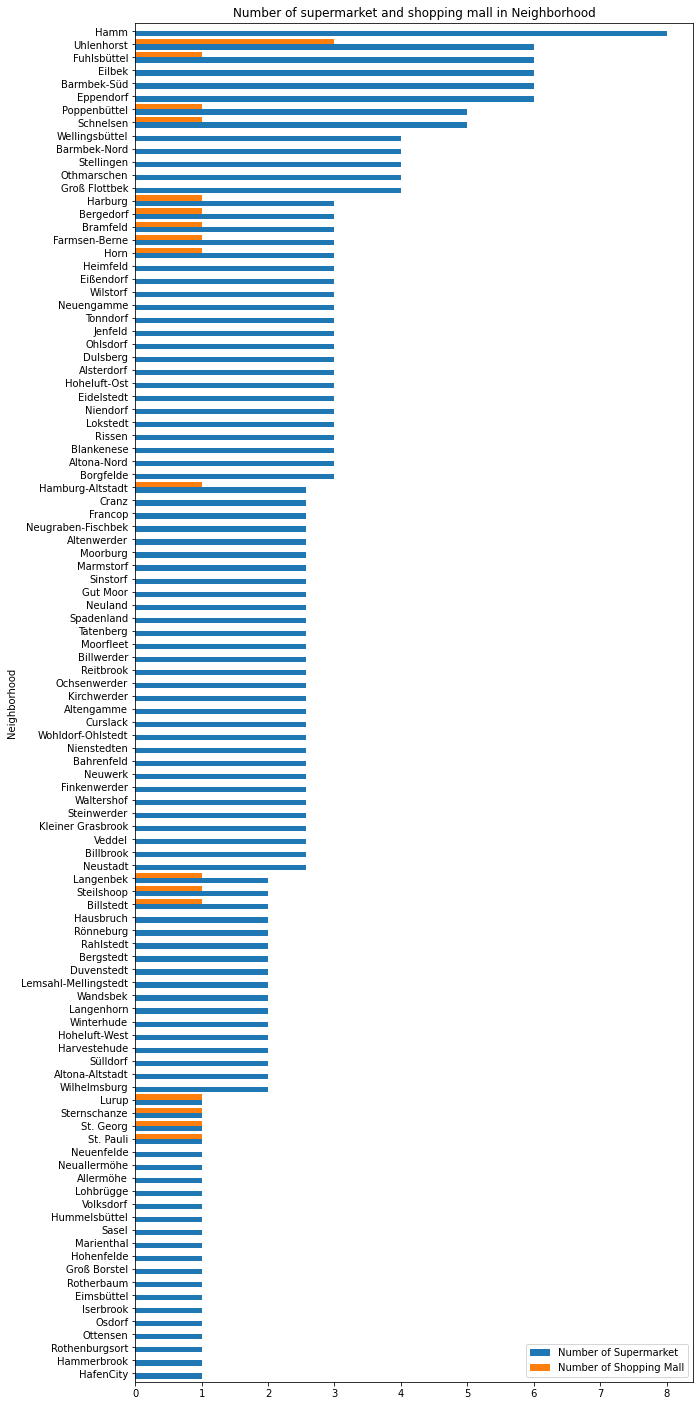

In [480]:
data_ss2[['Number of Supermarket', 'Number of Shopping Mall']].plot(kind='barh', figsize=(10, 25), width = 0.8)

#plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Number of supermarket and shopping mall in Neighborhood') # add title to the plot
plt.yticks (np.arange(104), data_ss2['Neighborhood'])
plt.show()

In [481]:
data_ss2.head(10)

,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude,Number of Supermarket,Number of Shopping Mall
1,HafenCity,Hamburg-Mitte,2239,53.541111,10.000278,1.0,0.0
5,Hammerbrook,Hamburg-Mitte,1540,53.545278,10.030556,1.0,0.0
11,Rothenburgsort,Hamburg-Mitte,1241,53.535000,10.040833,1.0,0.0
22,Ottensen,Altona,12709,53.553889,9.917778,1.0,0.0
27,Osdorf,Altona,3690,53.572778,9.846667,1.0,0.0
30,Iserbrook,Altona,4231,53.576389,9.823333,1.0,0.0
33,Eimsbüttel,Eimsbüttel,17577,53.575833,9.951667,1.0,0.0
34,Rotherbaum,Eimsbüttel,5661,53.568056,9.988333,1.0,0.0
44,Groß Borstel,Hamburg-Nord,2321,53.613611,9.982500,1.0,0.0
48,Hohenfelde,Hamburg-Nord,9122,53.561667,10.020833,1.0,0.0


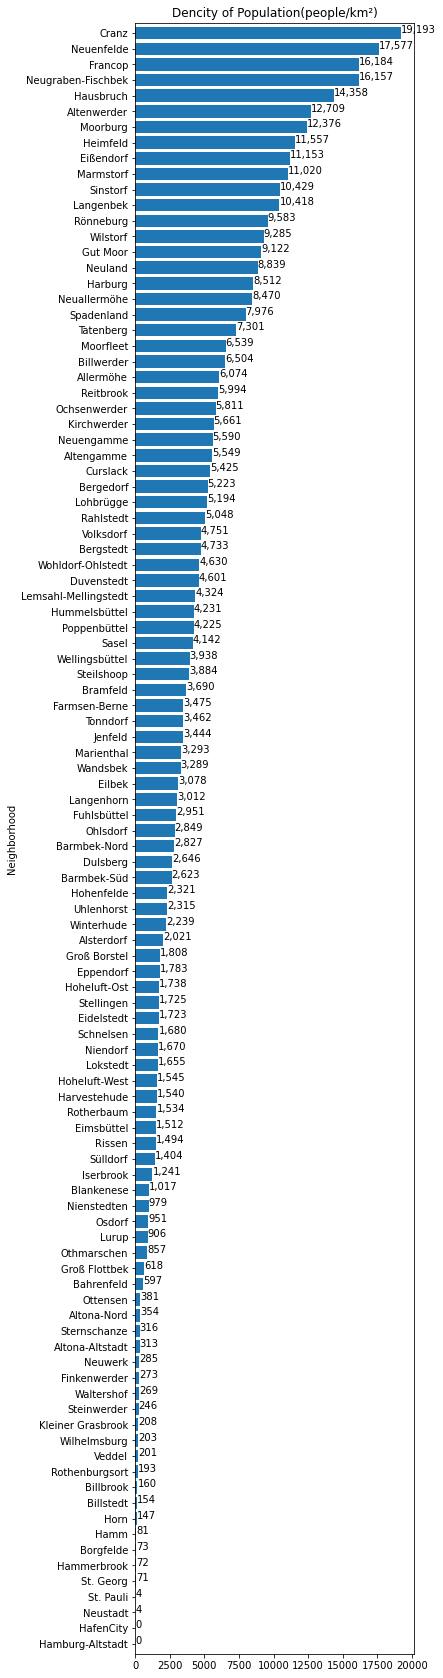

In [479]:
data_ss1['Dencity of Population(people/km²)'].plot(kind='barh', figsize=(5, 30), width = 0.8)

#plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Dencity of Population(people/km²)') # add title to the plot
plt.yticks (np.arange(104), data_ss['Neighborhood'])

for index, value in enumerate(data_ss1['Dencity of Population(people/km²)']):
    label = format(int(value), ',')
    plt.annotate(label, xy=(value, index), color='black')
plt.show()

## 4.3 Cluster Analysis

In [486]:
data_cluster = data_ss.drop(['Neighborhood', 'Borough', 'Latitude', 'Longitude'], axis=1)
data_cluster.head()

,Dencity of Population(people/km²),Number of Supermarket,Number of Shopping Mall
0,979,2.567568,1.0
1,2239,1.000000,0.0
2,5549,2.567568,0.0
3,8839,1.000000,1.0
4,4733,1.000000,1.0


In [487]:
from sklearn.preprocessing import StandardScaler
data_cluster = StandardScaler().fit_transform(data_cluster)
data_cluster

array([[-0.72639882,  0.        ,  1.79635381],
       [-0.43440786, -1.21133994, -0.40153791],
       [ 0.33264776,  0.        , -0.40153791],
       [ 1.0950686 , -1.21133994,  1.79635381],
       [ 0.14354885, -1.21133994,  1.79635381],
       [-0.59639332, -1.21133994, -0.40153791],
       [ 1.46353339,  0.33416274, -0.40153791],
       [ 1.26748231,  4.19791943, -0.40153791],
       [ 0.55395837,  0.33416274,  1.79635381],
       [ 0.00659119, -0.4385886 ,  1.79635381],
       [-0.88722559,  0.        , -0.40153791],
       [-0.66568324, -1.21133994, -0.40153791],
       [-0.71759274,  0.        , -0.40153791],
       [-0.60288201, -0.4385886 , -0.40153791],
       [-0.8962634 ,  0.        , -0.40153791],
       [-0.95234421,  0.        , -0.40153791],
       [-0.95327116,  0.        , -0.40153791],
       [-0.81492306,  0.        , -0.40153791],
       [-0.95234421,  0.        , -0.40153791],
       [ 1.46098426, -0.4385886 , -0.40153791],
       [ 2.79719051, -1.21133994,  1.796

To find the best K number:

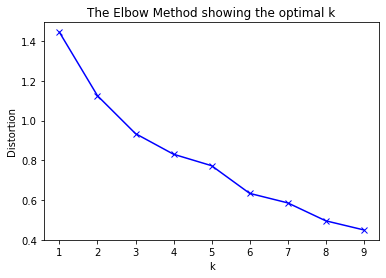

In [488]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data_cluster)
    kmeanModel.fit(data_cluster)
    distortions.append(sum(np.min(cdist(data_cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_cluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [489]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:103]

array([2, 0, 0, 2, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1,
       0, 0, 0, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
data_ss_final= data_ss.insert(0, 'Cluster Labels', kmeans.labels_)


In [508]:
data_ss.head(10)

,Cluster Labels,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude,Number of Supermarket,Number of Shopping Mall
0,2,Hamburg-Altstadt,Hamburg-Mitte,979,53.550000,10.000000,2.567568,1.0
1,0,HafenCity,Hamburg-Mitte,2239,53.541111,10.000278,1.000000,0.0
2,0,Neustadt,Hamburg-Mitte,5549,53.551944,9.985556,2.567568,0.0
3,2,St. Pauli,Hamburg-Mitte,8839,53.556944,9.963889,1.000000,1.0
4,2,St. Georg,Hamburg-Mitte,4733,53.555000,10.012222,1.000000,1.0
5,0,Hammerbrook,Hamburg-Mitte,1540,53.545278,10.030556,1.000000,0.0
6,1,Borgfelde,Hamburg-Mitte,10429,53.554722,10.034444,3.000000,0.0
7,1,Hamm,Hamburg-Mitte,9583,53.560833,10.057778,8.000000,0.0
8,2,Horn,Hamburg-Mitte,6504,53.553889,10.090000,3.000000,1.0
9,2,Billstedt,Hamburg-Mitte,4142,53.540556,10.101111,2.000000,1.0


Now, it's time to create maps representing our clusters. The first map is illustrating the clusters where the radius of the Circle marker is proportional to a Number of supermarket in each neighborhood.

In [512]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['#77C2B9', '#9A7FB8', '#7A8A92']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(data_ss['Latitude'], data_ss['Longitude'], data_ss['Neighborhood'], data_ss['Cluster Labels'], data_cluster[:,1]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius= 10,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [524]:

for lat, lng, Ladeeinrichtung in zip(data_fast_charging['Breitengrad [DG]'], data_fast_charging['Längengrad [DG]'], data_fast_charging['Steckertypen1']):
    label = '{}'.format(Ladeeinrichtung)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,).add_to(map_clusters)   

map_clusters

Then we can see the map with population dencisty in each neighborhood

In [522]:
# create the second map
map_clusters_2 = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['#4A8060', '#1760A0', '#C5B897']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the second map
markers_colors = []
for lat, lon, poi, cluster, income in zip(data_ss['Latitude'], data_ss['Longitude'], data_ss['Neighborhood'], data_ss['Cluster Labels'], data_ss['Dencity of Population(people/km²)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters_2)
       

# add the fast charging station to the map
for lat, lng, Ladeeinrichtung in zip(data_fast_charging['Breitengrad [DG]'], data_fast_charging['Längengrad [DG]'], data_fast_charging['Steckertypen1']):
    label = '{}'.format(Ladeeinrichtung)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,).add_to(map_clusters_2)  


map_clusters_2

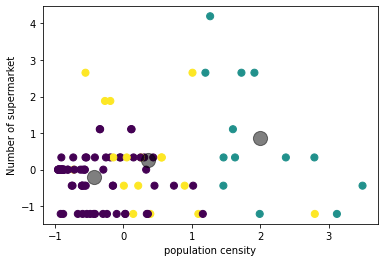

In [514]:
import matplotlib.pyplot as plt
y_kmeans = kmeans.predict(data_cluster)
plt.scatter(data_cluster[:, 0], data_cluster[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('population censity')
plt.ylabel('Number of supermarket')
plt.show()

In [525]:
data_ss[(data_ss['Cluster Labels'] == 0)]

,Cluster Labels,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude,Number of Supermarket,Number of Shopping Mall
1,0,HafenCity,Hamburg-Mitte,2239,53.541111,10.000278,1.000000,0.0
2,0,Neustadt,Hamburg-Mitte,5549,53.551944,9.985556,2.567568,0.0
5,0,Hammerbrook,Hamburg-Mitte,1540,53.545278,10.030556,1.000000,0.0
10,0,Billbrook,Hamburg-Mitte,285,53.527778,10.086111,2.567568,0.0
11,0,Rothenburgsort,Hamburg-Mitte,1241,53.535000,10.040833,1.000000,0.0
12,0,Veddel,Hamburg-Mitte,1017,53.516667,10.033333,2.567568,0.0
13,0,Wilhelmsburg,Hamburg-Mitte,1512,53.495000,10.011111,2.000000,0.0
14,0,Kleiner Grasbrook,Hamburg-Mitte,246,53.531111,9.993611,2.567568,0.0
15,0,Steinwerder,Hamburg-Mitte,4,53.534444,9.957222,2.567568,0.0
16,0,Waltershof,Hamburg-Mitte,0,53.527778,9.900556,2.567568,0.0


In [526]:
data_ss[(data_ss['Cluster Labels'] == 1)]

,Cluster Labels,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude,Number of Supermarket,Number of Shopping Mall
6,1,Borgfelde,Hamburg-Mitte,10429,53.554722,10.034444,3.0,0.0
7,1,Hamm,Hamburg-Mitte,9583,53.560833,10.057778,8.0,0.0
19,1,Altona-Altstadt,Altona,10418,53.548889,9.947778,2.0,0.0
21,1,Altona-Nord,Altona,11153,53.563056,9.945278,3.0,0.0
22,1,Ottensen,Altona,12709,53.553889,9.917778,1.0,0.0
33,1,Eimsbüttel,Eimsbüttel,17577,53.575833,9.951667,1.0,0.0
36,1,Hoheluft-West,Eimsbüttel,19193,53.580000,9.967222,2.0,0.0
42,1,Hoheluft-Ost,Hamburg-Nord,16157,53.584722,9.976111,3.0,0.0
43,1,Eppendorf,Hamburg-Nord,9285,53.595556,9.983889,6.0,0.0
49,1,Barmbek-Süd,Hamburg-Nord,11557,53.580000,10.040556,6.0,0.0


In [527]:
data_ss[(data_ss['Cluster Labels'] == 2)]

,Cluster Labels,Neighborhood,Borough,Dencity of Population(people/km²),Latitude,Longitude,Number of Supermarket,Number of Shopping Mall
0,2,Hamburg-Altstadt,Hamburg-Mitte,979,53.550000,10.000000,2.567568,1.0
3,2,St. Pauli,Hamburg-Mitte,8839,53.556944,9.963889,1.000000,1.0
4,2,St. Georg,Hamburg-Mitte,4733,53.555000,10.012222,1.000000,1.0
8,2,Horn,Hamburg-Mitte,6504,53.553889,10.090000,3.000000,1.0
9,2,Billstedt,Hamburg-Mitte,4142,53.540556,10.101111,2.000000,1.0
20,2,Sternschanze,Altona,16184,53.561667,9.962222,1.000000,1.0
26,2,Lurup,Altona,5811,53.593056,9.882778,1.000000,1.0
39,2,Schnelsen,Eimsbüttel,3289,53.633333,9.916667,5.000000,1.0
47,2,Uhlenhorst,Hamburg-Nord,8470,53.572500,10.018611,6.000000,3.0
53,2,Fuhlsbüttel,Hamburg-Nord,1723,53.634444,10.016111,6.000000,1.0


# 5. Conclusion and Discussion

At the end, we could summerize our analysis result that: 

Cluster 0 is the major group, which has low population density, low number of supermarket and shopping mall;
Cluster 2 is the second large group, which has high population density, middle number of super market and high number of shoping mall; 
Cluster 1 is the last group, which has high population density, high number of supermarket, and low number of shopping mall. As we can see, most of existing fast charging stations are located in Cluster 1. 

In order to reach the target of public charging stations in next few years, the analysis result would suggest to have more publich fast charging stations in Cluster 2. 

But anyhow, there is also some space to imporve this work:
1. Foursquare API is not the best options to explore and get more information. This can result the errors in the final analysis results. Maybe next time, it is great to try with Google Maps API.
2. For fast publich charging stations, it is also a good idea to use API to get real-time charging station information.
3. Given we also have the normal charging station data, it is also great to initiate another project on this topic. 


Finally, I certainly appreciate this project which allows me to recap all the knowledges I have gained in this course.


# 6.Reference

Data: 
1. Hamburg borough and neighborhood data
    >data source: Wikipedia 

2. The coordinations for the neighborhood
    >data source: Foursquare API

3. The existinng fast charging stations in Hamburg
    >data source: Bundestnetsagentur: https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/E-Mobilitaet/E-Mobilitaet-node.html  

4. The most popular venues/locations in Hamburg(assumming, there are the most visited public place, where people can access with e-cars.) The charging station shall be near by those places. 
    >data source: Foursquare
    
Literature:

[1]https://en.wikipedia.org/wiki/Electric_car_use_by_country

[2]https://elbe-hh.de/elbe/e-mobilitaet-in-hh

[3]https://www.bmvi.de/SharedDocs/DE/Anlage/G/masterplan-ladeinfrastruktur.pdf?__blob=publicationFile

[4]https://theicct.org/sites/default/files/publications/EV-charging-metrics-aug2020.pdf